In [364]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

index = 254460
seed = index
n_samples = 2560


syn1_x, syn1_t = make_classification(n_samples=n_samples, n_features=2, n_redundant=0, n_repeated=0, n_clusters_per_class=1, random_state=seed)
syn1_train_x, syn1_test_x, syn1_train_t, syn1_test_t = train_test_split(syn1_x, syn1_t, test_size=.2, random_state=seed)
min_max_scaler = preprocessing.MinMaxScaler()
syn1_train_x = min_max_scaler.fit_transform(syn1_train_x)
syn1_test_x = min_max_scaler.transform(syn1_test_x)
syn1_test_x_kl1 = syn1_test_x[syn1_test_t == 1]
syn1_test_x_kl2 = syn1_test_x[syn1_test_t == 0]

syn1_data = {
    'train': {
        'x': syn1_train_x,
        't': syn1_train_t
    },
    'test': {
        'x': syn1_test_x,
        't': syn1_test_t
    }
}

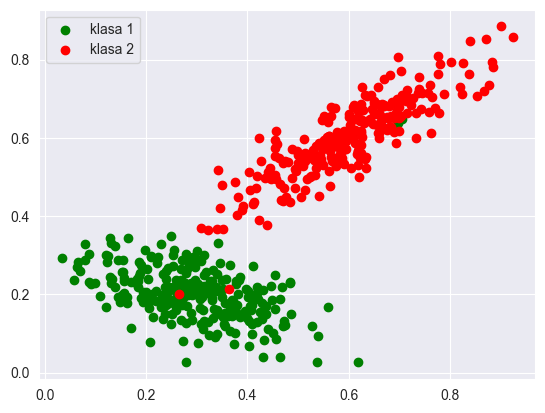

In [365]:
sns.set_style("darkgrid")


plt.scatter(syn1_test_x_kl1[:,0], syn1_test_x_kl1[:,1], c = "g", label="klasa 1")
plt.scatter(syn1_test_x_kl2[:,0], syn1_test_x_kl2[:,1], c = "r", label="klasa 2")
plt.legend()
plt.show()

In [366]:
from sklearn.linear_model import LogisticRegression


clf = LogisticRegression().fit(syn1_data["train"]["x"], syn1_data["train"]["t"])
clf.score(syn1_data["test"]["x"], syn1_data["test"]["t"])

0.984375

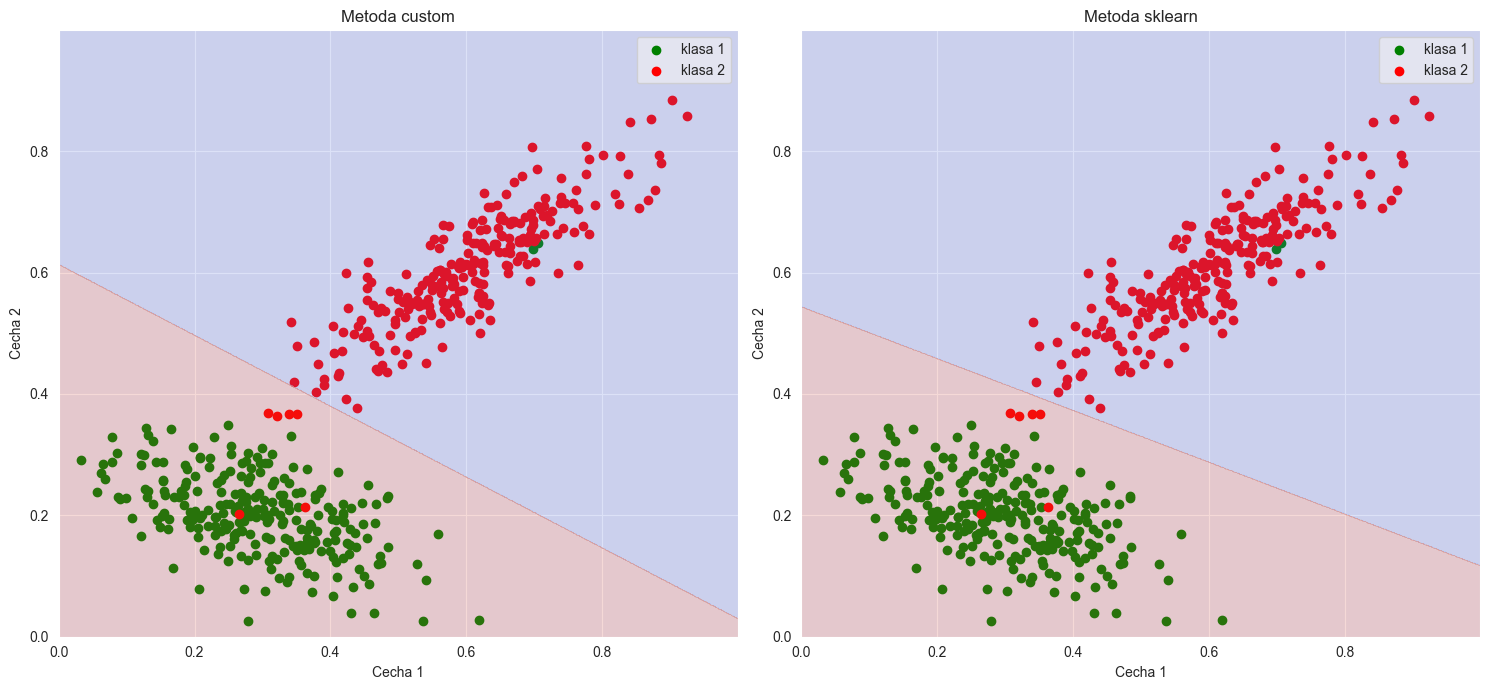

In [367]:
from sklearn.preprocessing import PolynomialFeatures
import statistics


class CustomLogisticRegression:
    def __init__(self, train_data, targets, epoch_nb, threshold, step) -> None:
        self.BETA = 1
        self.STEP = step
        self.THRESHOLD = threshold
        self.X = train_data
        self.targets = targets
        self.epoch_nb = epoch_nb
        self.teta = np.random.rand(train_data.shape[1],)
        self.cus_prob = np.zeros_like(targets)

    def F(self, S):
        #print(S)
        if S > 500:
            S = 500
        elif S < -500:
            S = -500
        res = np.array(1/(1+np.exp(-self.BETA*S)))
        return res
    
    def fit(self):
        for _ in range(self.epoch_nb):
            for i in range(X.shape[0]):
                self.teta = self.teta + (self.STEP*(self.targets[i] - self.F(self.teta.T@self.X[i])))*self.X[i]
            # E = [self.targets[i] - self.F(self.teta.T@self.X[i]) for i in range(X.shape[0])]
            # if statistics.mean(E) < self.THRESHOLD:
            #     break
    def predict(self, test_data):
        self.cus_prob = test_data@self.teta
        res = np.array([1 if score >= 0 else 0 for score in self.cus_prob])
        return res
    
    def score(self, predicted_val, true_val):
        j = 0
        for i, val in enumerate(true_val):
            if val == predicted_val[i]:
                j+=1
        score = j/len(predicted_val)
        return score

   


X = syn1_data["train"]["x"]
X = np.hstack([np.ones((X.shape[0], 1)), X])
logistic_regresion = CustomLogisticRegression(X, syn1_data["train"]["t"], 100, 0.01, 0.01)
#print(syn1_data["train"]["t"])
logistic_regresion.fit()
xx, yy = np.meshgrid(np.arange(0, 1, 0.001),
                     np.arange(0, 1, 0.001))
poly = PolynomialFeatures(degree=1, include_bias=True)
Z = poly.fit_transform(np.c_[xx.ravel(), yy.ravel()])
Z = logistic_regresion.predict(Z)
Z = Z.reshape(xx.shape)
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
ax = axs[0]
ax.scatter(syn1_test_x_kl1[:,0], syn1_test_x_kl1[:,1], c = "g", label="klasa 1")
ax.scatter(syn1_test_x_kl2[:,0], syn1_test_x_kl2[:,1], c = "r", label="klasa 2")
ax.contourf(xx, yy, Z, alpha=0.2, cmap=plt.cm.coolwarm)
ax.set_title("Metoda custom")
ax.set_xlabel("Cecha 1")
ax.set_ylabel("Cecha 2")
ax.legend()
ax = axs[1]
Z = np.c_[xx.ravel(), yy.ravel()]
Z = clf.predict(Z)
Z = Z.reshape(xx.shape)
ax.scatter(syn1_test_x_kl1[:,0], syn1_test_x_kl1[:,1], c = "g", label="klasa 1")
ax.scatter(syn1_test_x_kl2[:,0], syn1_test_x_kl2[:,1], c = "r", label="klasa 2")
ax.contourf(xx, yy, Z, alpha=0.2, cmap=plt.cm.coolwarm)
ax.set_title("Metoda sklearn")
ax.set_xlabel("Cecha 1")
ax.set_ylabel("Cecha 2")
ax.legend()
fig.tight_layout()

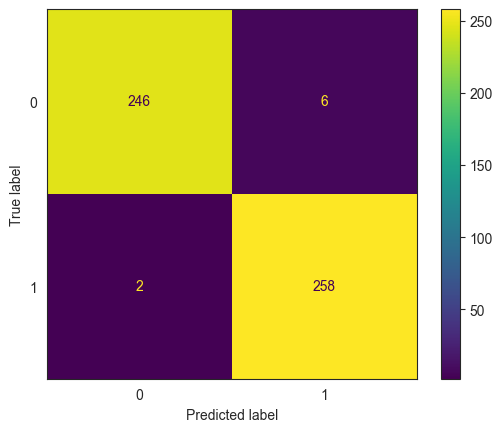

In [368]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


skl_y = clf.predict(syn1_data["test"]["x"])
sns.set_style("white")
cm_S = confusion_matrix(syn1_data["test"]["t"], skl_y)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_S)
disp.plot()
plt.show()

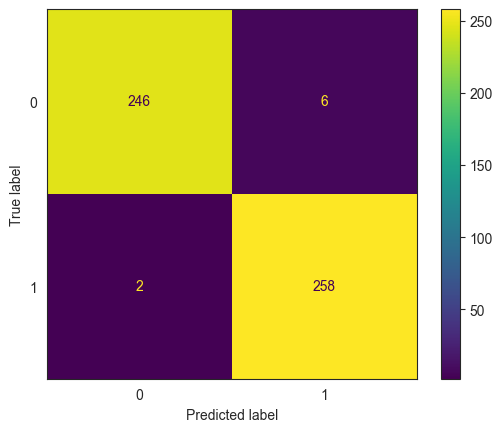

In [369]:
X = syn1_data["test"]["x"]
X = np.hstack([np.ones((X.shape[0], 1)), X])
cus_y = logistic_regresion.predict(X)
cm_S = confusion_matrix(syn1_data["test"]["t"], cus_y)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_S)
disp.plot()
plt.show()

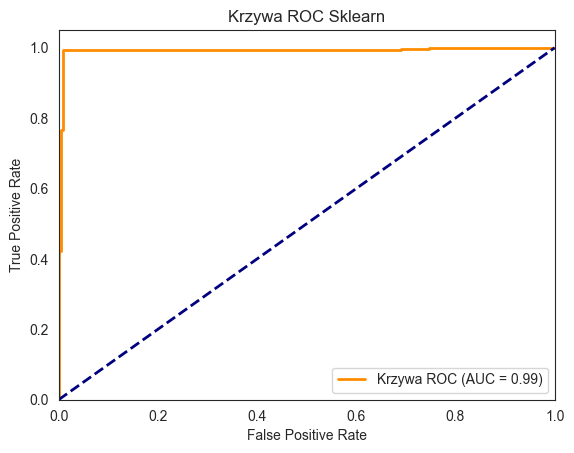

In [370]:
from sklearn.metrics import roc_curve, auc

skl_prob = clf.decision_function(syn1_data["test"]["x"])
fpr, tpr, thresholds = roc_curve(syn1_data["test"]["t"], skl_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Krzywa ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC Sklearn')
plt.legend(loc="lower right")
plt.show()

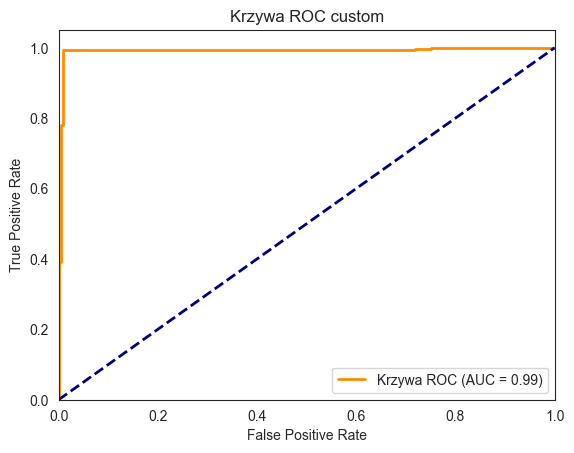

In [371]:
cus_prob = logistic_regresion.cus_prob
fpr, tpr, thresholds = roc_curve(syn1_data["test"]["t"], cus_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Krzywa ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC custom')
plt.legend(loc="lower right")
plt.show()

In [372]:
from sklearn.datasets import make_moons


syn2_x, syn2_y = make_moons(n_samples=n_samples, random_state=seed, noise=0.1)
syn2_train_x, syn2_test_x, syn2_train_t, syn2_test_t = train_test_split(syn2_x, syn2_y, test_size=.2, random_state=seed)
# syn2_train_x = min_max_scaler.fit_transform(syn2_train_x)
# syn2_test_x = min_max_scaler.transform(syn2_test_x)
syn2_test_x_kl1 = syn2_test_x[syn2_test_t == 0]
syn2_test_x_kl2 = syn2_test_x[syn2_test_t == 1]

syn2_data = {
    "train": 
    {
        "x" : syn2_train_x,
        "t" : syn2_train_t
    },
    "test":
    {
        "x" : syn2_test_x,
        "t" : syn2_test_t
    }
}

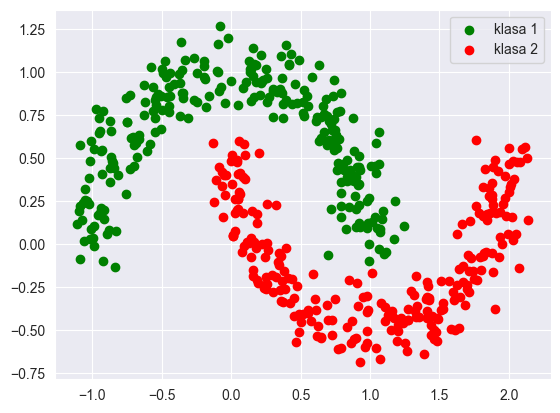

In [373]:
sns.set_style("darkgrid")


plt.scatter(syn2_test_x_kl1[:,0], syn2_test_x_kl1[:,1], c = "g", label="klasa 1")
plt.scatter(syn2_test_x_kl2[:,0], syn2_test_x_kl2[:,1], c = "r", label="klasa 2")
plt.legend()
plt.show()

In [374]:
poly = PolynomialFeatures(degree=3, include_bias=False)
X_train_pol = poly.fit_transform(syn2_data["train"]["x"])
X_test_pol = poly.fit_transform(syn2_data["test"]["x"])
clf = LogisticRegression().fit(X_train_pol, syn2_data["train"]["t"])
clf.score(X_test_pol, syn2_data["test"]["t"])

0.98828125

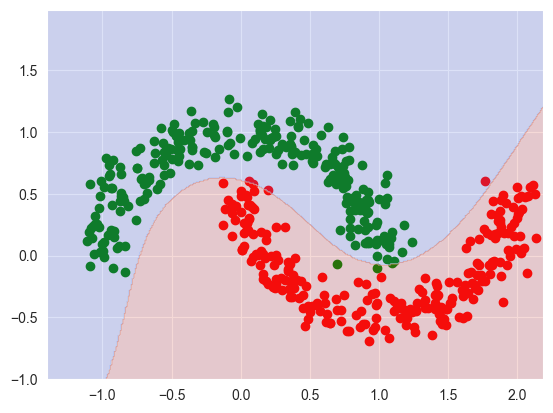

In [375]:
xx, yy = np.meshgrid(np.arange(-1.4, 2.2, 0.01),
                     np.arange(-1, 2, 0.01))
Z = poly.fit_transform(np.c_[xx.ravel(), yy.ravel()])
Z = clf.predict(Z)
Z = Z.reshape(xx.shape)
plt.scatter(syn2_test_x_kl1[:,0], syn2_test_x_kl1[:,1], c = "g", label="klasa 1")
plt.scatter(syn2_test_x_kl2[:,0], syn2_test_x_kl2[:,1], c = "r", label="klasa 2")
plt.contourf(xx, yy, Z, alpha=0.2, cmap=plt.cm.coolwarm)

In [376]:
poly = PolynomialFeatures(degree=3, include_bias=True)
X = syn2_data["train"]["x"]
X_train_pol = poly.fit_transform(X)
logistic_regresion = CustomLogisticRegression(X_train_pol, syn2_data["train"]["t"], 100, 0.001, 0.01)
logistic_regresion.fit()
X = syn2_data["test"]["x"]
X_test_pol = poly.fit_transform(X)

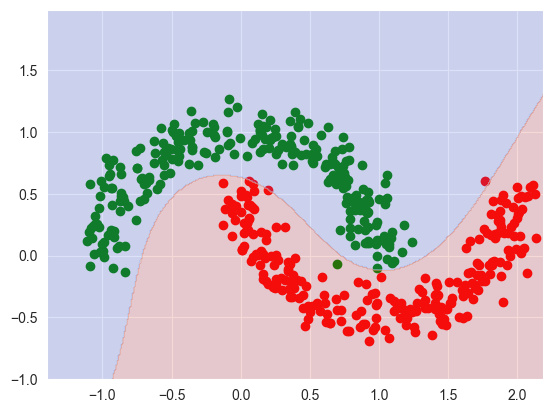

In [377]:
xx, yy = np.meshgrid(np.arange(-1.4, 2.2, 0.01),
                     np.arange(-1, 2, 0.01))
Z = poly.fit_transform(np.c_[xx.ravel(), yy.ravel()])
Z = logistic_regresion.predict(Z)
Z = Z.reshape(xx.shape)
plt.scatter(syn2_test_x_kl1[:,0], syn2_test_x_kl1[:,1], c = "g", label="klasa 1")
plt.scatter(syn2_test_x_kl2[:,0], syn2_test_x_kl2[:,1], c = "r", label="klasa 2")
plt.contourf(xx, yy, Z, alpha=0.2, cmap=plt.cm.coolwarm)

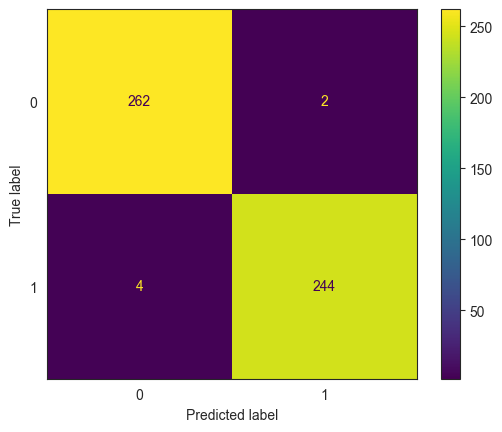

In [378]:
sns.set_style("white")


poly = PolynomialFeatures(degree=3, include_bias=False)
X = syn2_data["test"]["x"]
X_train_pol = poly.fit_transform(X)
skl_y = clf.predict(X_train_pol)
cm_S = confusion_matrix(syn2_data["test"]["t"], skl_y)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_S)
disp.plot()
plt.show()

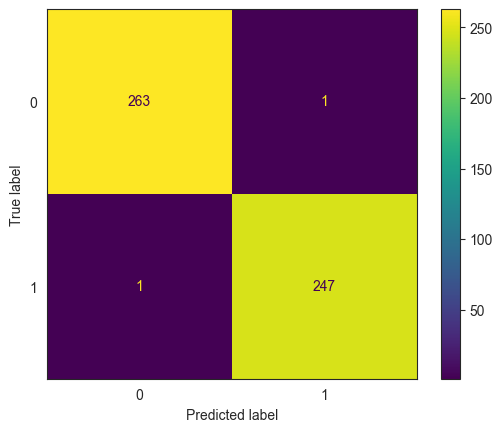

In [379]:
sns.set_style("white")


poly = PolynomialFeatures(degree=3, include_bias=True)
X = syn2_data["test"]["x"]
X_train_pol = poly.fit_transform(X)
cm_y = logistic_regresion.predict(X_train_pol)
cm_S = confusion_matrix(syn2_data["test"]["t"], cm_y)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_S)
disp.plot()
plt.show()

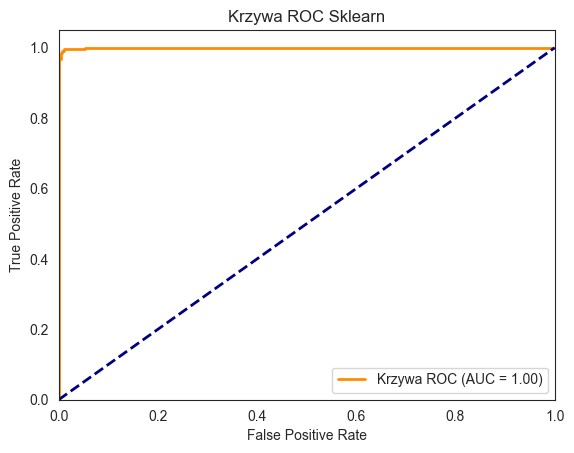

In [380]:
poly = PolynomialFeatures(degree=3, include_bias=False)
X = syn2_data["test"]["x"]
X_train_pol = poly.fit_transform(X)

skl_prob = clf.decision_function(X_train_pol)
fpr, tpr, thresholds = roc_curve(syn2_data["test"]["t"], skl_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Krzywa ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC Sklearn')
plt.legend(loc="lower right")
plt.show()

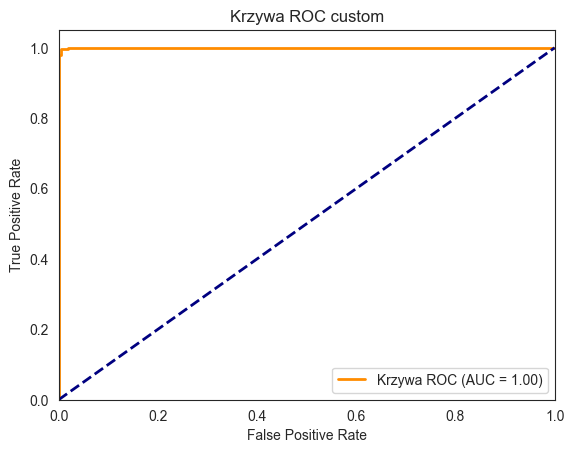

In [381]:
cus_prob = logistic_regresion.cus_prob
fpr, tpr, thresholds = roc_curve(syn2_data["test"]["t"], cus_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Krzywa ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC custom')
plt.legend(loc="lower right")
plt.show()

In [382]:
import pandas as pd


#import danych formatu CSV
with open("rainAUS.csv", "rb") as f:
    rain_data_df = pd.read_csv(f)
#usunięcie kolumn z brakami > 30%
missing_percentage = rain_data_df.isna().mean()*100
columns_to_drop = missing_percentage[missing_percentage > 30].index
rain_data_df = rain_data_df.drop(columns=columns_to_drop)
#uzupełnienie danych wartościami dominant oraz median
categorital_values = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']
numeric_values = ['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm']
for column in categorital_values:
    dominant_value = rain_data_df[column].mode()[0]
    rain_data_df[column] = rain_data_df[column].fillna(dominant_value)
for column in numeric_values:
    median_value = rain_data_df[column].median()
    rain_data_df[column] = rain_data_df[column].fillna(median_value)
#winsoryzacja danych
for column in numeric_values:
    column_data = rain_data_df[column]
    Q1 = column_data.quantile(0.25)
    Q3 = column_data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - IQR
    upper_bound  = Q3 + IQR
    rain_data_df[column] = rain_data_df[column].clip(lower=lower_bound, upper=upper_bound)
#grupowanie danych po regionach
grouped_data = rain_data_df.groupby('Location')
rain_data_by_locations = {}
local_names = grouped_data.groups.keys()
for group_name, group in grouped_data:
    #odseparowanie kolumny RainTomorrow
    rain_tomorrow_df = group.pop('RainTomorrow')
    rain_tomorrow_df = pd.DataFrame(rain_tomorrow_df)
    rain_tomorrow_df['RainTomorrow'] = rain_tomorrow_df['RainTomorrow'].map({'Yes': 1, 'No': 0})
    train_X, test_X, train_t, test_t = train_test_split(group, rain_tomorrow_df, test_size=.2, random_state=seed, stratify=rain_tomorrow_df)
    train_t = np.array(train_t)
    train_t = train_t.T
    train_t = np.squeeze(train_t)
    test_t = np.array(test_t)
    test_t = test_t.T
    test_t = np.squeeze(test_t)
    rain_data_by_locations[group_name] = {
    'train': {
        'x': train_X,
        't': train_t
    },
    'test': {
        'x': test_X,
        't': test_t
    }
}
#normalizacja danych numerycznych
categorital_values.pop()
for location in local_names:
    for numeric_val in numeric_values:
        min_max_scaler = preprocessing.MinMaxScaler()
        rain_data_by_locations[location]['train']['x'][numeric_val] = min_max_scaler.fit_transform(pd.DataFrame(rain_data_by_locations[location]['train']['x'][numeric_val]))
        rain_data_by_locations[location]['test']['x'][numeric_val] = min_max_scaler.transform(pd.DataFrame(rain_data_by_locations[location]['test']['x'][numeric_val]))
#kodowanie one-hot danych kategorycznych
for location in local_names:
    for categorical_value in categorital_values:
        #dla wartości treningowych
        encoded_df = pd.get_dummies(rain_data_by_locations[location]['train']['x'][categorical_value], prefix=categorical_value)
        rain_data_by_locations[location]['train']['x'] = rain_data_by_locations[location]['train']['x'].drop(categorical_value, axis="columns")
        rain_data_by_locations[location]['train']['x'] = pd.concat([rain_data_by_locations[location]['train']['x'], encoded_df], axis=1)
        #dla wartości testowych
        encoded_df = pd.get_dummies(rain_data_by_locations[location]['test']['x'][categorical_value], prefix=categorical_value)
        rain_data_by_locations[location]['test']['x'] = rain_data_by_locations[location]['test']['x'].drop(categorical_value, axis="columns")
        rain_data_by_locations[location]['test']['x'] = pd.concat([rain_data_by_locations[location]['test']['x'], encoded_df], axis=1)
    #transformacja daty
    rain_data_by_locations[location]['train']['x']['Date'] = pd.to_datetime(rain_data_by_locations[location]['train']['x']['Date'])
    rain_data_by_locations[location]['train']['x']['year'] = rain_data_by_locations[location]['train']['x'].Date.dt.year
    rain_data_by_locations[location]['train']['x']['day_of_year'] = rain_data_by_locations[location]['train']['x'].Date.dt.day_of_year
    rain_data_by_locations[location]['train']['x'].drop(columns=['Date'], inplace=True)
    #usunięcie kolumny location
    rain_data_by_locations[location]['train']['x'].drop(columns=['Location'], inplace=True)
    #transformacja daty
    rain_data_by_locations[location]['test']['x']['Date'] = pd.to_datetime(rain_data_by_locations[location]['test']['x']['Date'])
    rain_data_by_locations[location]['test']['x']['year'] = rain_data_by_locations[location]['test']['x'].Date.dt.year
    rain_data_by_locations[location]['test']['x']['day_of_year'] = rain_data_by_locations[location]['test']['x'].Date.dt.day_of_year
    rain_data_by_locations[location]['test']['x'].drop(columns=['Date'], inplace=True)
    #usunięcie kolumny location
    rain_data_by_locations[location]['test']['x'].drop(columns=['Location'], inplace=True)
#uzupełnienie braklujących kolumn
for location in local_names:
    rain_data_by_locations[location]['test']['x'] = rain_data_by_locations[location]['test']['x'].reindex(columns=rain_data_by_locations[location]['train']['x'].columns, fill_value=0)

In [383]:
#Wtrenowanie modeli dla każdego obszaru i znalezienie najlepszego wyniku
scores = []
for location in local_names:
    clf = LogisticRegression(max_iter=1000, tol=0.001, fit_intercept=False).fit(rain_data_by_locations[location]['train']['x'], rain_data_by_locations[location]['train']['t'])
    scores.append(clf.score(rain_data_by_locations[location]['test']['x'], rain_data_by_locations[location]['test']['t']))
local_names = list(local_names)
#best_location = local_names[scores.index(max(scores))]
best_location = "NorfolkIsland"
print(f"best score {best_location} {max(scores)}")

c:\Users\marci\miniconda3\envs\SWAD\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\marci\miniconda3\envs\SWAD\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

best score NorfolkIsland 0.9493670886075949


In [395]:
X = np.array(rain_data_by_locations[best_location]['train']['x'])
X = np.hstack([np.ones((X.shape[0], 1)), X])
seta = np.random.rand(X.shape[1],)
logistic_regresion = CustomLogisticRegression(X, rain_data_by_locations[best_location]['train']['t'], 500, 1e-4, 0.001)
logistic_regresion.fit()
X = np.array(rain_data_by_locations[best_location]['test']['x'])
X = np.hstack([np.ones((X.shape[0], 1)), X])
predicted = logistic_regresion.predict(X)
logistic_regresion.score(list(predicted), list(rain_data_by_locations[best_location]['test']['t']))

0.0

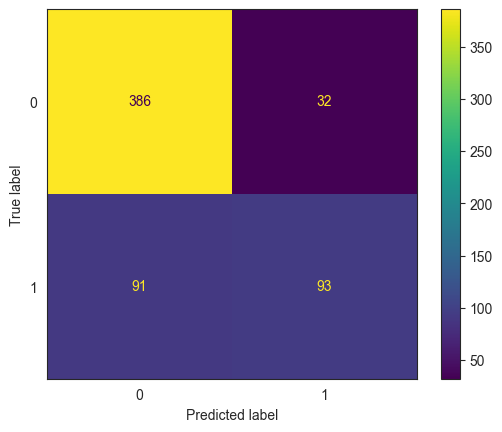

In [396]:
clf = LogisticRegression(solver='newton-cg', fit_intercept=True).fit(rain_data_by_locations[best_location]['train']['x'], rain_data_by_locations[best_location]['train']['t'])
skl_y = clf.predict(rain_data_by_locations[best_location]['test']['x'])
skl_S = confusion_matrix(rain_data_by_locations[best_location]['test']['t'], skl_y)
disp = ConfusionMatrixDisplay(confusion_matrix=skl_S)
disp.plot()
plt.show()

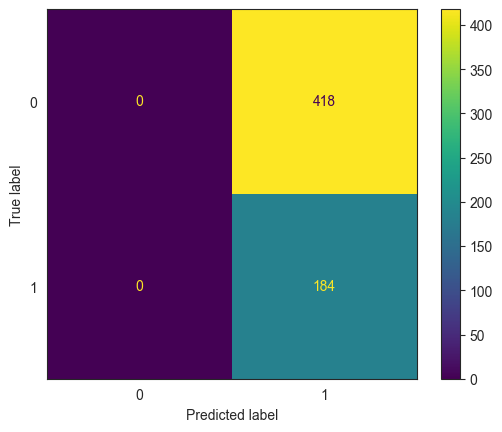

In [397]:
X = np.array(rain_data_by_locations[best_location]['test']['x'])
X = np.hstack([np.ones((X.shape[0], 1)), X])
cus_y = logistic_regresion.predict(X)
cm_S = confusion_matrix(rain_data_by_locations[best_location]['test']['t'], cus_y)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_S)
disp.plot()
plt.show()

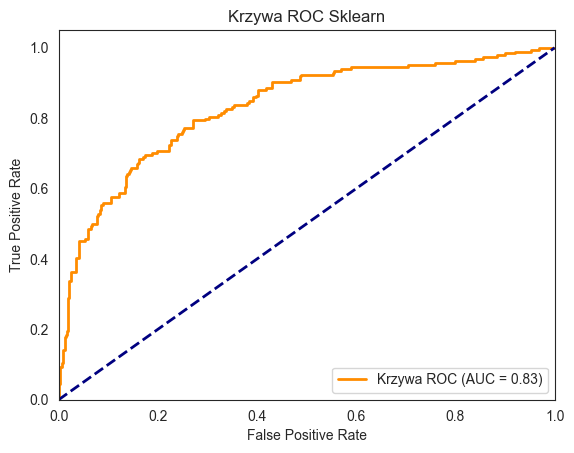

In [398]:
skl_prob = clf.decision_function(rain_data_by_locations[best_location]['test']['x'])
fpr, tpr, thresholds = roc_curve(rain_data_by_locations[best_location]['test']['t'], skl_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Krzywa ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC Sklearn')
plt.legend(loc="lower right")
plt.show()

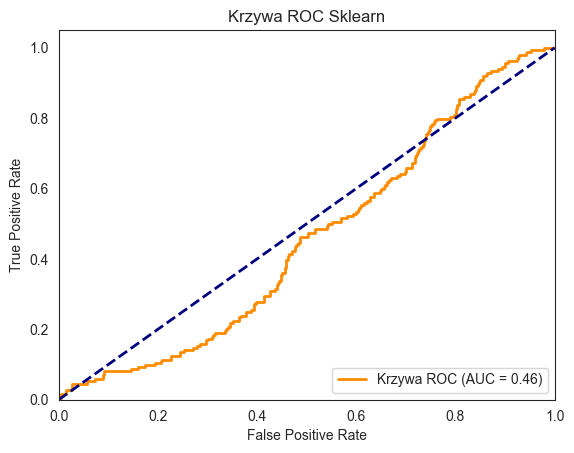

In [399]:
fpr, tpr, thresholds = roc_curve(rain_data_by_locations[best_location]['test']['t'], logistic_regresion.cus_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Krzywa ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC Sklearn')
plt.legend(loc="lower right")
plt.show()